In [1]:
import numpy as np
import random
import pandas as pd
import matplotlib.pyplot as plt
import scienceplots
plt.style.use(['science']) 
import os
os.environ["PATH"] += os.pathsep + '/Library/TeX/texbin'
from tqdm import tqdm

In [1061]:
triple_filename = "/Users/pranavsatheesh/Triples/Github/Triple-Outcomes/Data/Triple_outcomes_N_100.csv"
iso_binaries = "/Users/pranavsatheesh/Triples/Github/Triple-Outcomes/Data/iso_binaries_w_kick.csv"
weak_triples = "/Users/pranavsatheesh/Triples/Github/Triple-Outcomes/Data/weak_triples_w_kick.csv"

df_trips = pd.read_csv(triple_filename) 
df_trips[:520].head()
df_weak_triples = pd.read_csv(weak_triples)
df_iso = pd.read_csv(iso_binaries) 
df_iso.head()

,M1,M2,qin,t_merger,z_merger,gw_kick_random,gw_kick_5deg,gw_kick_hybrid,merger_flag,bhid1,bhid2,f-gas,Vescape
0,2.260508e+06,1.628522e+06,0.720423,8.585867e+08,6.460270,1642.197401,121.342563,475.666929,Yes,9223372036326575607,9223372036365264250,0.736201,1066.081124
1,1.614294e+06,1.077030e+06,0.667183,8.924214e+08,6.270490,514.319208,207.823426,1279.928514,Yes,9223372036330308081,9223372036383756962,0.851595,1124.251110
2,6.552913e+06,1.175374e+06,0.179367,3.833599e+09,1.720798,468.004339,186.556456,386.483624,Yes,9223372036306477048,9223372036351439102,0.192233,3225.589960
3,2.594471e+06,1.828861e+06,0.704907,1.008202e+09,5.702360,1108.016303,98.974368,456.108562,Yes,9223372036405417417,9223372036501930090,0.155198,411.624105
4,6.833995e+06,1.227516e+06,0.179619,3.200552e+09,2.080566,441.869692,171.821326,180.177179,Yes,9223372036315813145,9223372036570133338,0.653175,1214.901739


In [1062]:
bhid_cols_in_iso_bins = {"bhid1","bhid2"}
bhid_cols_in_trips = {"bhid1","bhid2","bhid3","bhid4"}

In [1101]:
def GW_recoil_ejec_from_iso_binaries(kick_name,df_iso,df_weak_trip,df_strong_trip):
    kick_type = "gw_kick_"+ kick_name
    iso_kick_eject_mask = (df_iso[kick_type])>(df_iso["Vescape"])
    #iso_invalid_merger_flags = np.ones(len(df_iso))*-1
    iso_invalid_merger_flags = []
    weak_triple_invalid_merger_flags = []
    strong_triple_invalid_merger_flags = []

    ejec_N = len(df_iso[iso_kick_eject_mask])


    for bhid_col1 in bhid_cols_in_iso_bins:
        for bhid_col2 in bhid_cols_in_iso_bins:
            for i in range(ejec_N):
                idx1_common_id = df_iso[iso_kick_eject_mask][bhid_col1].index[i]
                bhid_to_find = df_iso[iso_kick_eject_mask][bhid_col1].iloc[i]
                idxs_in_common = df_iso.index[df_iso[bhid_col2] == bhid_to_find].tolist()

                if(idxs_in_common):
                    for all_common_ixs in idxs_in_common:
                        if(df_iso["t_merger"].iloc[idx1_common_id]<df_iso["t_merger"].iloc[all_common_ixs]):
                            iso_invalid_merger_flags.append(all_common_ixs)
        
        for bhid_col2 in bhid_cols_in_trips:
            for i in range(ejec_N):
                idx1_common_id = df_iso[iso_kick_eject_mask][bhid_col1].index[i]
                bhid_to_find = df_iso[iso_kick_eject_mask][bhid_col1].iloc[i]
                idxs_in_common_in_weak_triples = df_weak_trip.index[df_weak_trip[bhid_col2] == bhid_to_find].tolist() #in weak triples
                idxs_in_common_in_strong_triples = df_strong_trip.index[df_strong_trip[bhid_col2] == bhid_to_find].tolist() #in weak triples

                if(idxs_in_common_in_weak_triples):
                    for all_common_ixs in idxs_in_common_in_weak_triples:
                        if(df_iso["t_merger"].iloc[idx1_common_id]<df_weak_trip["t_triple_form"].iloc[all_common_ixs]):
                            weak_triple_invalid_merger_flags.append(all_common_ixs)
                
                if(idxs_in_common_in_strong_triples):
                    for all_common_ixs in idxs_in_common_in_strong_triples:
                        if(df_iso["t_merger"].iloc[idx1_common_id]<df_strong_trip["t_triple_form"].iloc[all_common_ixs]):
                            strong_triple_invalid_merger_flags.append(all_common_ixs)                    

    iso_invalid_merger_flags = np.unique(np.array(iso_invalid_merger_flags))
    weak_triple_invalid_merger_flags = np.unique(np.array(weak_triple_invalid_merger_flags))
    strong_triple_invalid_merger_flags = np.unique(np.array(strong_triple_invalid_merger_flags))
    
    print("Found %d iso_binary mergers invalid due to ejections via GW %s kick"%(len(iso_invalid_merger_flags),kick_name))
    invalid_merger_col_name = "invalid_merger_"+kick_name
    df_iso[invalid_merger_col_name] = df_iso.index.isin(iso_invalid_merger_flags)

    print("Found %d binary mergers in weak triples invalid due to ejections via GW %s kick"%(len(weak_triple_invalid_merger_flags),kick_name))
    df_weak_trip[invalid_merger_col_name] = df_weak_trip.index.isin(weak_triple_invalid_merger_flags)

    print("Found %d binary mergers in strong triples invalid due to ejections via GW %s kick"%(len(strong_triple_invalid_merger_flags)/100,kick_name))
    df_strong_trip[invalid_merger_col_name] = df_strong_trip.index.isin(strong_triple_invalid_merger_flags)    

In [776]:
GW_recoil_ejec_from_iso_binaries("random",df_iso,df_weak_triples,df_trips)

Found 87 iso_binary mergers invalid due to ejections via GW random kick
Found 46 binary mergers in weak triples invalid due to ejections via GW random kick
Found 15 binary mergers in strong triples invalid due to ejections via GW random kick


In [1103]:
def GW_recoil_ejec_from_weak_triples(kick_name,df_iso,df_weak_trip,df_strong_trip):
    kick_type = "gw_kick_"+ kick_name
    kick_eject_mask = (df_weak_trip[kick_type])>(df_weak_trip["Vescape"])
    #iso_invalid_merger_flags = np.ones(len(df_iso))*-1
    iso_invalid_merger_flags = []
    weak_triple_invalid_merger_flags = []
    strong_triple_invalid_merger_flags = []

    ejec_N = len(df_weak_trip[kick_eject_mask])


    for bhid_col1 in bhid_cols_in_iso_bins:
        for bhid_col2 in bhid_cols_in_iso_bins:
            for i in range(ejec_N):
                idx1_common_id = df_weak_trip[kick_eject_mask][bhid_col1].index[i]
                bhid_to_find = df_weak_trip[kick_eject_mask][bhid_col1].iloc[i]
                idxs_in_common = df_iso.index[df_iso[bhid_col2] == bhid_to_find].tolist()

                if(idxs_in_common):
                    for all_common_ixs in idxs_in_common:
                        if(df_weak_triples["t_triple_form"].iloc[idx1_common_id]<df_iso["t_merger"].iloc[all_common_ixs]):
                            iso_invalid_merger_flags.append(all_common_ixs)
        
        for bhid_col2 in bhid_cols_in_trips:
            for i in range(ejec_N):
                idx1_common_id = df_weak_trip[kick_eject_mask][bhid_col1].index[i]
                bhid_to_find = df_weak_trip[kick_eject_mask][bhid_col1].iloc[i]
                idxs_in_common_in_weak_triples = df_weak_trip.index[df_weak_trip[bhid_col2] == bhid_to_find].tolist() #in weak triples
                idxs_in_common_in_strong_triples = df_strong_trip.index[df_strong_trip[bhid_col2] == bhid_to_find].tolist() #in weak triples

                if(idxs_in_common_in_weak_triples):
                    for all_common_ixs in idxs_in_common_in_weak_triples:
                        if(df_weak_trip["t_triple_form"].iloc[idx1_common_id]<df_weak_trip["t_triple_form"].iloc[all_common_ixs]):
                            weak_triple_invalid_merger_flags.append(all_common_ixs)
                
                if(idxs_in_common_in_strong_triples):
                    for all_common_ixs in idxs_in_common_in_strong_triples:
                        if(df_weak_trip["t_triple_form"].iloc[idx1_common_id]<df_strong_trip["t_triple_form"].iloc[all_common_ixs]):
                            strong_triple_invalid_merger_flags.append(all_common_ixs)

    iso_invalid_merger_flags = np.unique(np.array(iso_invalid_merger_flags))
    weak_triple_invalid_merger_flags = np.unique(np.array(weak_triple_invalid_merger_flags))
    strong_triple_invalid_merger_flags = np.unique(np.array(strong_triple_invalid_merger_flags))
    
    print("Found %d iso_binary mergers invalid due to ejections via GW %s kick"%(len(iso_invalid_merger_flags),kick_name))
    invalid_merger_col_name = "invalid_merger_"+kick_name
    df_iso[invalid_merger_col_name] = df_iso[invalid_merger_col_name] | df_iso.index.isin(iso_invalid_merger_flags)
    

    print("Found %d binary mergers in weak triples invalid due to ejections via GW %s kick"%(len(weak_triple_invalid_merger_flags),kick_name))
    df_weak_trip[invalid_merger_col_name] = df_weak_trip[invalid_merger_col_name] | df_weak_trip.index.isin(weak_triple_invalid_merger_flags)

    print("Found %d binary mergers in strong triples invalid due to ejections via GW %s kick"%(len(strong_triple_invalid_merger_flags)/100,kick_name))
    df_strong_trip[invalid_merger_col_name] = df_strong_trip[invalid_merger_col_name] | df_strong_trip.index.isin(strong_triple_invalid_merger_flags) 

In [1104]:
GW_recoil_ejec_from_weak_triples("random",df_iso,df_weak_triples,df_trips)

Found 102 iso_binary mergers invalid due to ejections via GW random kick
Found 23 binary mergers in weak triples invalid due to ejections via GW random kick
Found 22 binary mergers in strong triples invalid due to ejections via GW random kick


In [1105]:
def find_m3_bhid(row):
    bhid1 = row['bhid1']
    bhid2 = row['bhid2']
    bhid3 = row['bhid3']
    bhid4 = row['bhid4']
    
    if bhid1 == bhid3 or bhid2 == bhid3:
        return bhid4
    elif bhid1 == bhid4 or bhid2 == bhid4:
        return bhid3
    else:
        return None

In [1106]:
df_trips["m3_id"] = df_trips.apply(find_m3_bhid, axis=1)

In [1107]:
df_trips["m1_id"] = df_trips["bhid1"]
df_trips["m2_id"] = df_trips["bhid2"]

In [1108]:
def GW_recoil_ejec_from_strong_triples(kick_name,df_iso,df_weak_trip,df_strong_trip):
    kick_type = "gw_kick_"+ kick_name
    kick_eject_mask = (df_strong_trip[kick_type])>(df_strong_trip["Vescape"])
    #iso_invalid_merger_flags = np.ones(len(df_iso))*-1
    iso_invalid_merger_flags = []
    weak_triple_invalid_merger_flags = []
    strong_triple_invalid_merger_flags = []

    ejec_N = len(df_strong_trip[kick_eject_mask])


    for i in tqdm(range(ejec_N),desc="Iterating over strong triple case"):
        if((df_strong_trip[kick_eject_mask]["M3"].iloc[i] < df_strong_trip[kick_eject_mask]["M1"].iloc[i]) and (df_strong_trip[kick_eject_mask]["M3"].iloc[i] < df_strong_trip[kick_eject_mask]["M2"].iloc[i])):
            bhid_cols_in_strong_trip = ["m1_id","m2_id"]
        else:
            bhid_cols_in_strong_trip = ["m1_id","m3_id"]

        for bhid_col1 in bhid_cols_in_strong_trip:
            for bhid_col2 in bhid_cols_in_iso_bins:
                idx1_common_id = df_strong_trip[kick_eject_mask][bhid_col1].index[i]
                bhid_to_find = df_strong_trip[kick_eject_mask][bhid_col1].iloc[i]
                idxs_in_common = df_iso.index[df_iso[bhid_col2] == bhid_to_find].tolist()

                if(idxs_in_common):
                    for all_common_ixs in idxs_in_common:
                        if(df_strong_trip["t_merger"].iloc[idx1_common_id]<df_iso["t_merger"].iloc[all_common_ixs]):
                            iso_invalid_merger_flags.append(all_common_ixs)

            for bhid_col2 in bhid_cols_in_trips:
                idx1_common_id = df_strong_trip[kick_eject_mask][bhid_col1].index[i]
                bhid_to_find = df_strong_trip[kick_eject_mask][bhid_col1].iloc[i]

                idxs_in_common_in_weak_triples = df_weak_trip.index[df_weak_trip[bhid_col2] == bhid_to_find].tolist() #in weak triples
                idxs_in_common_in_strong_triples = df_strong_trip.index[df_strong_trip[bhid_col2] == bhid_to_find].tolist() #in weak triples

                if(idxs_in_common_in_weak_triples):
                    for all_common_ixs in idxs_in_common_in_weak_triples:
                        if(df_strong_trip["t_merger"].iloc[idx1_common_id]<df_weak_trip["t_triple_form"].iloc[all_common_ixs]):
                            weak_triple_invalid_merger_flags.append(all_common_ixs)
                
                if(idxs_in_common_in_strong_triples):
                    for all_common_ixs in idxs_in_common_in_strong_triples:
                        if(df_strong_trip["t_merger"].iloc[idx1_common_id]<df_strong_trip["t_triple_form"].iloc[all_common_ixs]):
                            strong_triple_invalid_merger_flags.append(all_common_ixs)

    iso_invalid_merger_flags = np.unique(np.array(iso_invalid_merger_flags))
    weak_triple_invalid_merger_flags = np.unique(np.array(weak_triple_invalid_merger_flags))
    strong_triple_invalid_merger_flags = np.unique(np.array(strong_triple_invalid_merger_flags))
    
    print("Found %d iso_binary mergers invalid due to ejections via GW %s kick"%(len(iso_invalid_merger_flags),kick_name))
    invalid_merger_col_name = "invalid_merger_"+kick_name
    df_iso[invalid_merger_col_name] = df_iso[invalid_merger_col_name] | df_iso.index.isin(iso_invalid_merger_flags)
    

    print("Found %d binary mergers in weak triples invalid due to ejections via GW %s kick"%(len(weak_triple_invalid_merger_flags),kick_name))
    df_weak_trip[invalid_merger_col_name] = df_weak_trip[invalid_merger_col_name] | df_weak_trip.index.isin(weak_triple_invalid_merger_flags)

    print("Found %d binary mergers in strong triples invalid due to ejections via GW %s kick"%(len(strong_triple_invalid_merger_flags)/100,kick_name))
    df_strong_trip[invalid_merger_col_name] = df_strong_trip[invalid_merger_col_name] | df_strong_trip.index.isin(strong_triple_invalid_merger_flags) 

In [1109]:
GW_recoil_ejec_from_strong_triples("random",df_iso,df_weak_triples,df_trips)

Iterating over strong triple case: 100%|██████████| 3910/3910 [00:56<00:00, 69.21it/s]

Found 164 iso_binary mergers invalid due to ejections via GW random kick
Found 7 binary mergers in weak triples invalid due to ejections via GW random kick
Found 21 binary mergers in strong triples invalid due to ejections via GW random kick


In [1110]:
len(df_trips[:520][df_trips[:520]["invalid_merger_random"]==True])

73

In [1111]:
len(df_iso[df_iso["invalid_merger_random"]==True])

907

In [1112]:
len(df_weak_triples[df_weak_triples["invalid_merger_random"]==True])

99

In [1113]:
(343+73+52)/9234 * 100

5.0682261208577

In [1114]:
#need to add Slingshot recoil here

In [1115]:
import Merger_rate_plot as mr

In [1116]:
len(df_iso)

3875

In [1117]:
binary_merger_z = df_iso[df_iso["invalid_merger_random"]==False]["z_merger"]
binary_mr,lgzbins_bin,dNdlogzdt_bin = mr.merger_rate_log_plot(binary_merger_z,zmax=4,zbinsize=0.01,lgzbinsize=0.15,lgzmin=-3,lgzmax=1.0)



weak_trip_z = df_weak_triples[(df_weak_triples["invalid_merger_random"]==False) & (df_weak_triples["bin_merger_flag"]=="Yes")]["z_merger"]
weak_mr,lgzweak_bin,dNdlogzdt_weak = mr.merger_rate_log_plot(weak_trip_z,zmax=4,zbinsize=0.01,lgzbinsize=0.15,lgzmin=-3,lgzmax=1.0)

In [1118]:
import astropy.units as u
from astropy.cosmology import WMAP9 as cosmo
from astropy.cosmology import z_at_value
from astropy import constants as const


boxsize = 75.0
omega_m = 0.2726
omega_l = 0.7274
h = 0.704
vol_comov_box = (boxsize/h)**3 #Mpc^3



def unit_comoving_vol(z):

    D_H = const.c.to('km/s').value/cosmo.H0.value
    return D_H * cosmo.comoving_transverse_distance(z).value**2 * cosmo.inv_efunc(z)
    

In [1119]:
len(df_iso["z_merger"])

3875

In [1120]:
len(binary_merger_z)

2968

In [1121]:
M1_iso = df_iso[df_iso["invalid_merger_random"]==False]["M1"]
M2_iso = df_iso[df_iso["invalid_merger_random"]==False]["M2"]

In [1122]:
t_m = df_iso[df_iso["invalid_merger_random"]==False]["t_merger"]
z_m = df_iso[df_iso["invalid_merger_random"]==False]["z_merger"]

In [1123]:
Mchirp_iso = (M1_iso*M2_iso)**(3/5)/(M1_iso + M2_iso)**(1/5)
df_iso["Mchirp"] = Mchirp_iso
Mmin=6
Mmax = 9
Mbinsize = 0.5

In [1124]:
Mchirp_0,Mbin_edges_0 = np.histogram(np.log10(df_iso["Mchirp"]),range=(Mmin,Mmax),bins=int(Mmax/Mbinsize))
Mchirp_1,Mbin_edges_1 = np.histogram(np.log10(df_iso[df_iso["invalid_merger_random"]==False]["Mchirp"]),range=(Mmin,Mmax),bins=int(Mmax/Mbinsize))

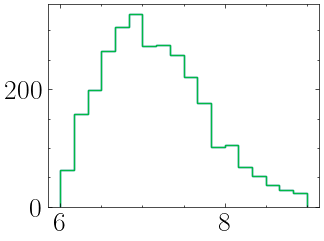

In [1125]:
plt.stairs(Mchirp_0,Mbin_edges_0)
plt.stairs(Mchirp_1,Mbin_edges_1)

In [1126]:
df_run = []
Nruns=100
Ntriple = int(len(df_trips["M1"])/Nruns)

for i in range(Ntriple):
    df_i = df_trips[Ntriple*i:Ntriple*(i+1)]
    df_run.append(df_i)

In [1127]:
zmax = 8
zbinsize = 0.5

In [1128]:
len(df_iso["z_merger"].to_list())

3875

In [1129]:
len(df_run[i][df_run[i]["merger_flag"]!="No"]["z_merger"].to_list())

0

In [1130]:
#without ejections 
binary_merger_z = df_iso["z_merger"].to_list()
weak_trip_z = df_weak_triples["z_merger"][df_weak_triples["bin_merger_flag"]=="Yes"].to_list()
print(len(binary_merger_z),len(weak_trip_z))
total_merger_z = []
for i in range(Nruns):
    N_z,zbin_edges = np.histogram(binary_merger_z+weak_trip_z+df_run[i][df_run[i]["merger_flag"]!="No"]["z_merger"].to_list(),range=(0,zmax),bins=int(zmax/zbinsize))
    total_merger_z.append(N_z)

3875 387


In [1131]:
len(df_run[i][(df_run[i]["merger_flag"]!="No")&(df_run[i]["invalid_merger_random"]==False)]["z_merger"].to_list())

214

In [1132]:
#with ejections 
binary_merger_z = df_iso[df_iso["invalid_merger_random"]==False]["z_merger"].to_list()
weak_trip_z = df_weak_triples[(df_weak_triples["invalid_merger_random"]==False)&(df_weak_triples["bin_merger_flag"]=="Yes")]["z_merger"].to_list()
print(len(binary_merger_z),len(weak_trip_z))
total_merger_with_ejection_z = []
for i in range(Nruns):
    N_z,zbin_edges_with_ejection = np.histogram(binary_merger_z+weak_trip_z+df_run[i][(df_run[i]["merger_flag"]!="No")&(df_run[i]["invalid_merger_random"]==False)]["z_merger"].to_list(),range=(0,zmax),bins=int(zmax/zbinsize))
    total_merger_with_ejection_z.append(N_z)

2968 367


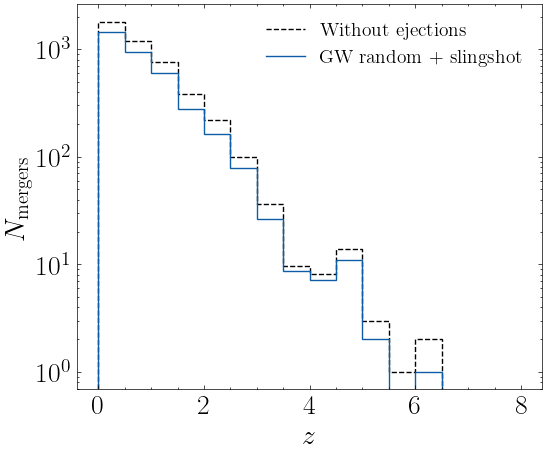

In [1133]:
fig,ax = plt.subplots(1,figsize=[6,5])

ax.stairs(np.mean(total_merger_z,axis=0),zbin_edges,linestyle="--",color="k",label="Without ejections")
ax.stairs(np.mean(total_merger_with_ejection_z,axis=0),zbin_edges_with_ejection,label="GW random + slingshot")
ax.set_yscale("log")
ax.set_xticks([0,2,4,6,8])
ax.set_yscale("log")
ax.set_yticks([1e0,1e1,1e2,1e3])
ax.set_ylabel(r"$N_{\text{mergers}}$")
ax.set_xlabel("$z$")
ax.legend(fontsize=14)
plt.show()

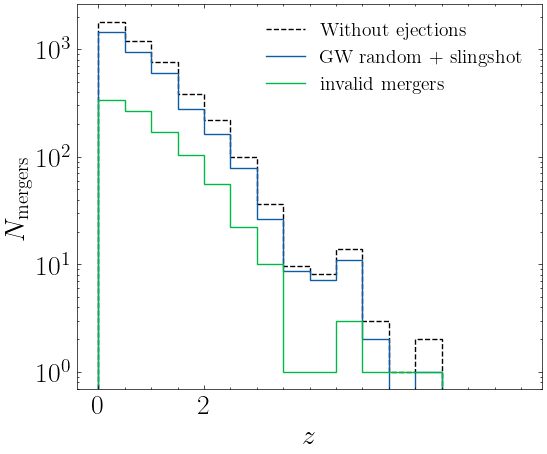

In [1134]:
fig,ax = plt.subplots(1,figsize=[6,5])

ax.stairs(np.mean(total_merger_z,axis=0),zbin_edges,linestyle="--",color="k",label="Without ejections")
ax.stairs(np.mean(total_merger_with_ejection_z,axis=0),zbin_edges_with_ejection,label="GW random + slingshot")

ax.stairs(np.mean(total_merger_z,axis=0)-np.mean(total_merger_with_ejection_z,axis=0),zbin_edges_with_ejection,label="invalid mergers")

ax.set_yscale("log")
ax.set_xticks([0,2])
ax.set_yscale("log")
ax.set_yticks([1e0,1e1,1e2,1e3])
ax.set_ylabel(r"$N_{\text{mergers}}$")
ax.set_xlabel("$z$")
ax.legend(fontsize=14)
plt.show()


In [803]:
Nruns = 100

def merger_rate_per_run(df,zmax=4,zbinsize=0.01,lgzbinsize=0.2,lgzmin=-3.0,lgzmax=1.0):

    
    Tr_prompt = df[(df["merger_flag"]=="Tr-12") | (df["merger_flag"]=="Tr-13") | (df["merger_flag"]=="Tr-23")]["z_merger"]
    Tr_prompt_mr,Tr_prompt_lgzbins,Tr_prompt_rate = mr.merger_rate_log_plot(Tr_prompt,zmax,zbinsize,lgzbinsize,lgzmin,lgzmax)


    Tr_ej_z = df[(df["merger_flag"]=="Tr-ej")]["z_merger"]
    Tr_ej_mr,Tr_ej_lgzbins,Tr_ej_rate = mr.merger_rate_log_plot(Tr_ej_z,zmax,zbinsize,lgzbinsize,lgzmin,lgzmax) 

    return Tr_prompt_lgzbins,[Tr_prompt_mr,Tr_prompt_rate,Tr_ej_mr,Tr_ej_rate]

def triple_outcomes_merger_rate(df_run,zmax,zbinsize,lgzbinsize,lgzmin,lgzmax):

    net_mr_Tr = []
    net_mr_Tr_ej = []
   

    mr_Tr = []
    mr_Tr_ej = []


    for i in range(Nruns):
        mr_out = merger_rate_per_run(df_run[i],zmax,zbinsize,lgzbinsize,lgzmin,lgzmax)[1:][0]
        net_mr_Tr.append(mr_out[0])
        mr_Tr.append(mr_out[1])
        net_mr_Tr_ej.append(mr_out[2])
        mr_Tr_ej.append(mr_out[3])

    lgzbins = merger_rate_per_run(df_run[i],zmax,zbinsize,lgzbinsize,lgzmin,lgzmax)[0]
    mr_Tr  = np.array(mr_Tr)
    mr_Tr_ej = np.array(mr_Tr_ej)
    net_mr_Tr_ej = np.array(net_mr_Tr_ej)
    net_mr_Tr = np.array(net_mr_Tr)

    return lgzbins,mr_Tr,mr_Tr_ej,net_mr_Tr,net_mr_Tr_ej

def triple_merger_after_ejec_rate(df_run,zmax,zbinsize,lgzbinsize,lgzmin,lgzmax):

    mr_Tr_ej = []
    for i in range(Nruns):
        df = df_run[i]
        Tr_ej_z = df[(df["merger_flag"]=="Tr-ej")]["z_merger"]
        Tr_ej_mr,Tr_ej_lgzbins,Tr_ej_rate = mr.merger_rate_log_plot(Tr_ej_z,zmax,zbinsize,lgzbinsize,lgzmin,lgzmax) 
        mr_Tr_ej.append(Tr_ej_rate)

    return Tr_ej_lgzbins,mr_Tr_ej

In [804]:
df_trips

,M1,M2,M3,qin,qout,t_merger,z_merger,a_triple_int,merger_flag,Slingshot_kick,...,bhid1,bhid2,bhid3,bhid4,f-gas,Vescape,invalid_merger_random,m3_id,m1_id,m2_id
0,2.119978e+07,3.473441e+06,2.463118e+07,0.163843,0.998296,1.752527e+09,3.630205,0.035402,Tr-ej,2201.057217,...,9223372036337899864,9223372036518620732,9223372036417148615,9223372036518620732,0.381619,3429.773746,False,9223372036417148615,9223372036337899864,9223372036518620732
1,2.391268e+08,1.296146e+08,1.287504e+07,0.542033,0.034916,1.139149e+10,0.192264,0.213378,Tr-ej,803.621211,...,9223372036342602658,9223372036486077725,9223372036486077725,9223372036893973198,0.595837,1390.661938,False,9223372036893973198,9223372036342602658,9223372036486077725
2,2.122135e+08,1.477407e+08,6.859143e+06,0.696189,0.019056,8.375550e+10,0.000000,0.056183,No,1611.662895,...,9223372036798549652,9223372036831413043,9223372036831413043,9223372039019874757,0.845373,851.131643,False,9223372039019874757,9223372036798549652,9223372036831413043
3,8.239502e+07,5.113722e+07,4.296126e+06,0.620635,0.032173,1.037072e+11,0.000000,0.071615,No,851.491213,...,9175344300051172004,9223372036970140153,9223372036970140153,9223372040703864032,0.874041,827.301270,False,9223372040703864032,9175344300051172004,9223372036970140153
4,4.625245e+07,8.973635e+06,2.419779e+06,0.194014,0.043816,4.006093e+10,0.000000,0.166512,No,270.385087,...,9223372036604300802,9223372036858472384,9223372036849763822,9223372036858472384,0.811056,498.691989,False,9223372036849763822,9223372036604300802,9223372036858472384
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
51995,2.367520e+07,3.030512e+06,1.673779e+07,0.128004,0.626749,1.294413e+10,0.061043,2.497594,Tr-23,24.399273,...,9223372040375713266,9223372045484968503,7221722345150349362,9223372045484968503,0.374991,1191.524846,False,7221722345150349362,9223372040375713266,9223372045484968503
51996,2.502891e+08,2.214000e+07,1.692168e+06,0.088458,0.006211,1.370878e+10,0.004275,0.078199,Tr-ej,666.054238,...,9223372049114720240,9223372055732073132,9223372045467470339,9223372055732073132,0.086260,2177.574975,False,9223372045467470339,9223372049114720240,9223372055732073132
51997,1.326529e+07,8.323477e+06,6.823273e+06,0.627463,0.316057,4.017351e+10,0.000000,26.476924,No,14.972200,...,9223372039881730251,9223372050382395178,9223372048715447446,9223372050382395178,0.593342,927.018908,False,9223372048715447446,9223372039881730251,9223372050382395178
51998,4.601341e+07,9.537147e+06,5.338969e+07,0.207269,0.961101,1.731119e+10,0.000000,106.494514,No,51.340700,...,9223372039071111476,9223372060383036336,9223372055084457209,9223372060383036336,0.330675,1574.831536,False,9223372055084457209,9223372039071111476,9223372060383036336


In [810]:
df_run = []

Ntriple = int(len(df_trips["M1"])/Nruns)

for i in range(Ntriple):
    df_i = df_trips[Ntriple*i:Ntriple*(i+1)][df_trips[Ntriple*i:Ntriple*(i+1)]["invalid_merger_random"]==False]
    df_run.append(df_i)

In [819]:
lgzbins,Tr_prompt,Tr_after_ej,net_Tr,net_Tr_ej = triple_outcomes_merger_rate(df_run,zmax=4,zbinsize=0.01,lgzbinsize=0.15,lgzmin=-3,lgzmax=1.0)

In [816]:
#lgzbins_Tr_plot,Tr_p,Tr_a_ej,net_Tr,net_Tr_ej  = triple_outcomes_merger_rate(df_run,zmax=4,zbinsize=0.01,lgzbinsize=0.3,lgzmin=-3,lgzmax=1.0)

In [900]:
binary_mr

0.31289372234881047

In [824]:
net_merger_rate = binary_mr+np.mean(net_Tr)+np.mean(net_Tr_ej)+weak_mr
print(net_merger_rate)

0.343545949260361


In [832]:
filepath='/Users/pranavsatheesh/Triples/Github/Illustris_Data/'
#lgztrip_bins,alltrip_mr = np.loadtxt(filepath+"triple_system.txt")
lgz_bins,all_mr = np.loadtxt(filepath+"all_system.txt")

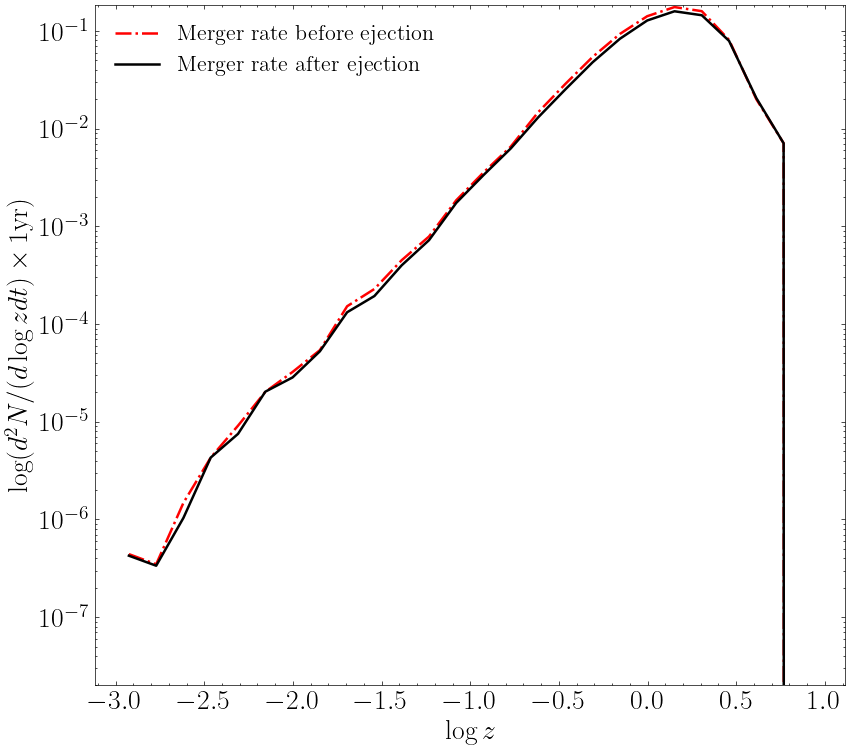

In [836]:
plt.figure(figsize=(9,8))
plt.rcParams.update({'font.size': 20})
plt.plot(lgz_bins,all_mr,color="red",linestyle="-.",label="Merger rate before ejection",linewidth=1.8)
plt.plot(lgzbins,dNdlogzdt_bin+np.mean(Tr_prompt+Tr_after_ej,axis=0)+dNdlogzdt_weak,color="black",linestyle="-",linewidth=1.8,label="Merger rate after ejection")
plt.ylim(2*10**-8,)
plt.yscale("log")
plt.xlabel("$\log z$",fontsize=20)
plt.ylabel(r"$\log (d^2 N / (d \log z dt)  \times 1\text{yr})$",fontsize=20)
plt.legend(fontsize=16)
plt.tight_layout()